This is where I'm importing the gauge data from the 2 USGS tab-separated files I've got and the waterwatch website, as well as organizing it into a useful form. This is all going to be very-specifcally set up for my specific instance just because I really don't forsee using it for anything else

In [1]:
import urllib3 as url
import re
import datetime as dt
import pickle
import json
import matplotlib.pyplot as plt 
import cartopy 
import cartopy.crs as ccrs 
http = url.PoolManager()

In [60]:
#This first one pulls each gauge number and it's lat lon coords
gauge_filepath = r'C:\Users\bpara\Geo data\Site coordinates.txt'
raw_coords = open(gauge_filepath, 'r')
gauge_final = dict()
first_line = True
for x in raw_coords:
    if first_line: 
        first_line = False
        continue
    if not x.split()[0] in gauge_final:
        temp = {"lat":x.split("	")[7], "lon":x.split("	")[8]}
        gauge_final[x.split()[0]] = temp

In [61]:
#This one pulls the maximum gauge height and flow in 2019 data for each gauge we have that data for
hgt_filepath = r'C:\Users\bpara\Geo data\Gauge Data.txt'
raw_hgt = open(hgt_filepath, 'r')
for line in raw_hgt:
    station = line.split('\t')[1]
    hgt = line.split('\t')[6]
    flow = line.split('\t')[4]
    if station not in gauge_final: continue
    gauge_final[station]["hgt"] = hgt
    gauge_final[station]["flow"] = flow
    if hgt == '' or flow == '':
        del gauge_final[station]

In [66]:
#And this one gets the NWS flood stages for each gauge where they exist
for gauge in gauge_final.keys():
    t1 = dt.datetime.now()
    site_num = gauge
    site2 = http.request('GET', "https://waterwatch.usgs.gov/webservices/floodstage?format=json&site=" + site_num)
    temp = json.loads(site2.data.decode("utf-8"))["sites"]
    if len(temp) != 0:
        stage_data = temp[0]
        del stage_data["site_no"]
        gauge_final[gauge]["stage"] = stage_data
    print("Done in " + str(dt.datetime.now() - t1))
file = open("USGS Gauge data", "wb")
pickle.dump(gauge_final, file)
file.close()

Done in 0:00:00.994766
Done in 0:00:00.732522
Done in 0:00:00.676933
Done in 0:00:00.685398
Done in 0:00:00.664251
Done in 0:00:00.659840
Done in 0:00:00.730296
Done in 0:00:00.666120
Done in 0:00:00.682471
Done in 0:00:00.737555
Done in 0:00:00.654716
Done in 0:00:00.667538
Done in 0:00:00.645078
Done in 0:00:00.679225
Done in 0:00:00.677735
Done in 0:00:00.659282
Done in 0:00:00.655038
Done in 0:00:00.666833
Done in 0:00:00.753243
Done in 0:00:01.134437
Done in 0:00:00.732987
Done in 0:00:00.735002
Done in 0:00:00.743720
Done in 0:00:00.728538
Done in 0:00:00.751491
Done in 0:00:00.746440
Done in 0:00:00.743247
Done in 0:00:00.798364
Done in 0:00:00.764966
Done in 0:00:00.818995
Done in 0:00:00.819075
Done in 0:00:00.731672
Done in 0:00:00.745132
Done in 0:00:00.755330
Done in 0:00:00.740874
Done in 0:00:00.791008
Done in 0:00:01.170006
Done in 0:00:01.161676
Done in 0:00:01.147663
Done in 0:00:00.948972
Done in 0:00:00.820564
Done in 0:00:00.864510
Done in 0:00:00.797145
Done in 0:0

In [2]:
with open("USGS Gauge data", 'rb') as f:
    gauge_final = pickle.load(f)

In [3]:
#prune to just the gauges where we have all 5 data points
bad_data = []
for gauge in gauge_final.keys():
    if 'lat' not in gauge_final[gauge] or 'lon' not in gauge_final[gauge] or 'hgt' not in gauge_final[gauge] or 'flow' not in gauge_final[gauge] or 'stage' not in gauge_final[gauge]:
        bad_data.append(gauge)
for gauge in bad_data:
    del gauge_final[gauge]

In [4]:
#identify which flood stage (if any) each gauge reached.
# 0: no flood
# 1: Action stage
# 2: Flood stage
# 3: Moderate flood stage
# 4: Major flood stage
for gauge in gauge_final.keys():
    hgt = gauge_final[gauge]['hgt']
    action = gauge_final[gauge]['stage']['action_stage']
    flood = gauge_final[gauge]['stage']['flood_stage']
    moderate = gauge_final[gauge]['stage']['moderate_flood_stage']
    major = gauge_final[gauge]['stage']['major_flood_stage']
    result = 0
    if action != None and float(hgt) >= float(action): result = 1
    if flood != None and float(hgt) >= float(flood): result = 2
    if moderate != None and float(hgt) >=float(moderate): result = 3
    if major != None and float(hgt) >= float(major): result = 4
    gauge_final[gauge]['flood stage'] = result

In [5]:
file = open("USGS Gauge data", "wb")
pickle.dump(gauge_final, file)
file.close()

In [150]:
#trim to the gauges with peak discharge of above 100 
gauge_trimmed = dict()
print(len(gauge_trimmed))
for gauge in gauge_final.keys():
    if float(gauge_final[gauge]['flow']) >=20000:
        gauge_trimmed[gauge] = gauge_final[gauge]
file = open("USGS Gauge trimmed data", "wb")
pickle.dump(gauge_trimmed, file)
file.close()    

0


In [151]:
x_vals = []
y_vals = []
colors = []
for gauge in gauge_trimmed.keys():
    x_vals.append(float(gauge_trimmed[gauge]['lon']))
    y_vals.append(float(gauge_trimmed[gauge]['lat']))
    colors.append(gauge_trimmed[gauge]['flood stage'])

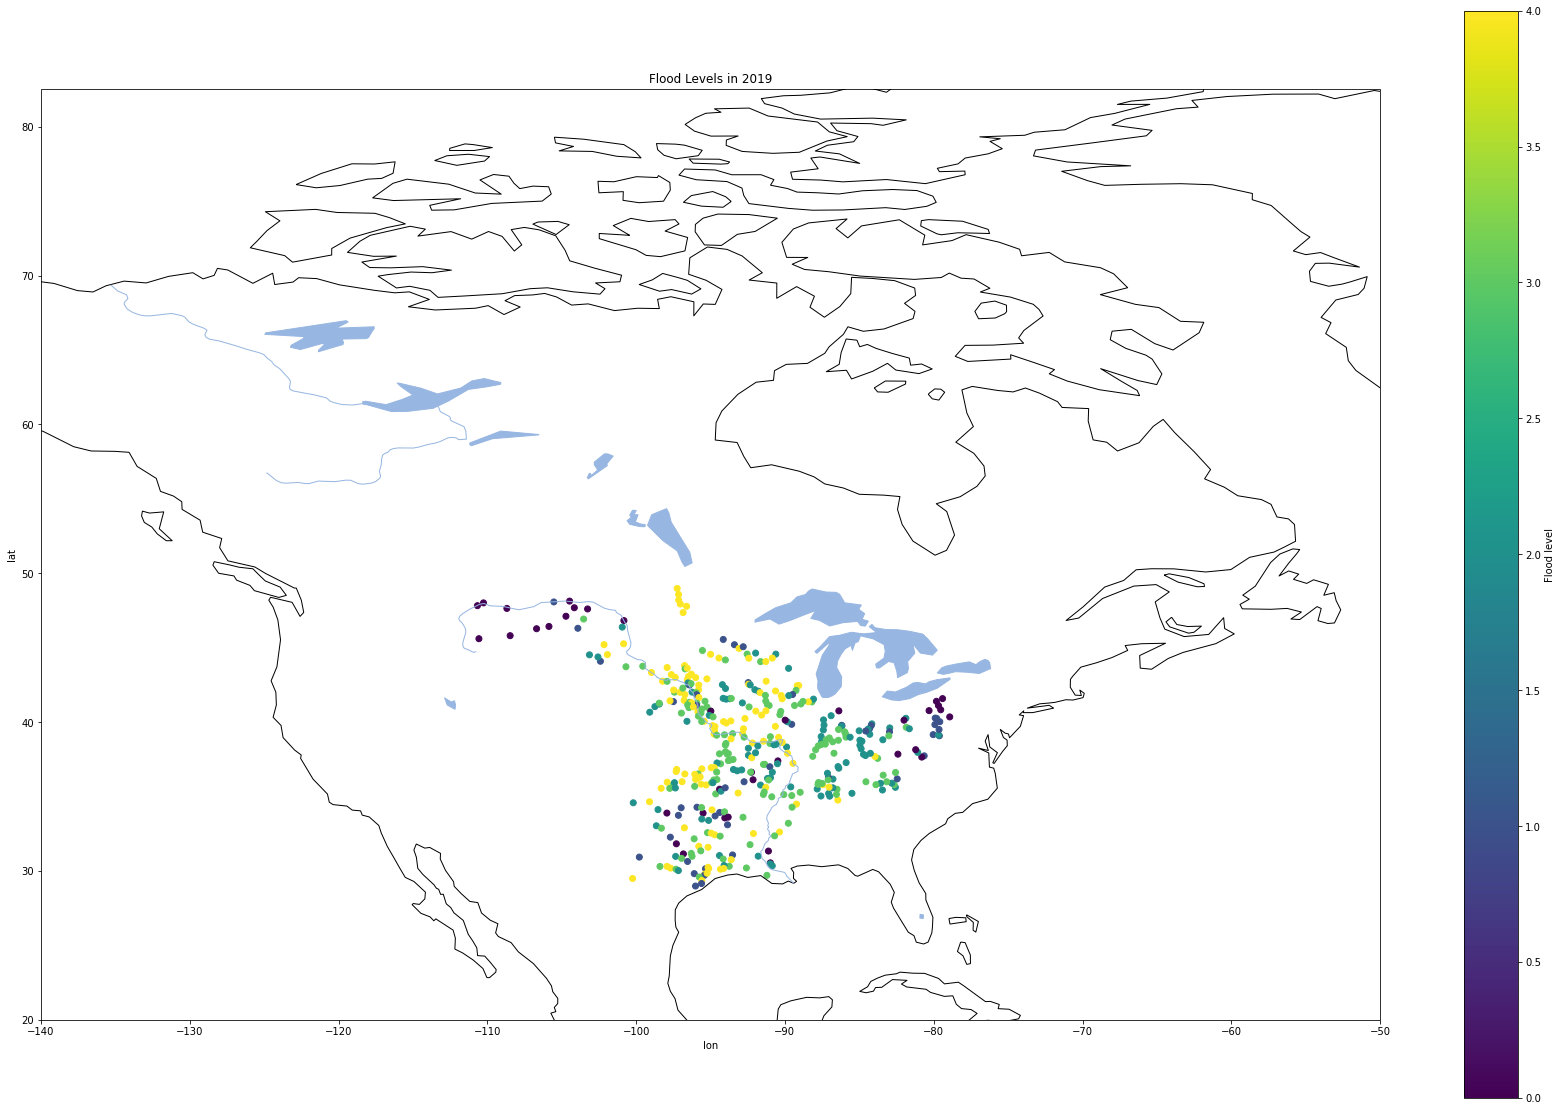

In [152]:
fig = plt.figure(figsize = (30, 20))
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = 0))
ax.coastlines()
ax.add_feature(cartopy.feature.LAKES, alpha=1)
ax.add_feature(cartopy.feature.RIVERS, alpha = 1)

ax.set_extent((-140, -50, 20, 80))
ax.set_xticks([-140, -130, -120, -110, -100, -90, -80, -70, -60, -50], crs = ccrs.PlateCarree())
ax.set_yticks([20, 30, 40, 50, 60, 70, 80], crs = ccrs.PlateCarree())
plt.xlabel('lon')
plt.ylabel('lat')
plt.title("Flood Levels in 2019")

points = plt.scatter(x_vals, y_vals, c=colors)
cbar = plt.colorbar(points)
cbar.set_label("Flood level")